In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import os
from collections import OrderedDict, Counter
import torch
import random
from itertools import accumulate

In [2]:
def get_provo_data(input_data):
    """A function that takes all .json files we created with info for the Provo Corpus
    and merges it into one dictionary"""
    
    #We merge all information in one dictionary
    # Each data point corresponds to all the information relevant to us for a given context in Provo Corpus
    joint_dict = {}
    
    count = 0
    for filename in input_data:
        f = open(filename)
        data = json.load(f)
        f.close()

        for text_id in data.keys():
            if (int(text_id) > 0) & (int(text_id) <= 40):
                for word_num in data[text_id].keys():
                    joint_dict[count] = data[text_id][word_num]
                    joint_dict[count]['original_positioning'] = {'text_id':text_id, 'word_num':word_num}
                
                    count = count + 1

    return joint_dict

In [3]:
os.chdir(os.path.join(os.getcwd(), 'TVD/GPT2/Generations'))

input_data = ['Paragraphs-1-1.json', 'Paragraphs-2-2.json', 'Paragraphs-3-3.json',
    'Paragraphs-4-4.json', 'Paragraphs-5-9.json', 'Paragraphs-10-14.json', 
    'Paragraphs-15-19.json', 'Paragraphs-20-24.json', 'Paragraphs-25-29.json',
    'Paragraphs-30-34.json', 'Paragraphs-35-39.json', 'Paragraphs-40-44.json', 
    'Paragraphs-45-47.json', 'Paragraphs-48-50.json', 'Paragraphs-51-53.json',
     'Paragraphs-54-55.json']

dataset = get_provo_data(input_data)

In [4]:
def model_unbiased(data_per_context):
    support_model = [x['pred'].lower() for x in data_per_context['ancestral_samples']]
    counts_model = [x['count'] for x in data_per_context['ancestral_samples']]
    #remove duplicates
    all_words = [[support_model[i]]* counts_model[i] for i in range(len(support_model))]
    all_words = [item for sublist in all_words for item in sublist]
    dict_dist = dict(Counter(all_words))

    words = list(dict_dist.keys())
    counts = list(dict_dist.values())
    probs = [x / sum(counts) for x in counts]

    return words, probs

In [5]:
def subsample_dist(data_per_context, sizes):
    support_model = [x['pred'].lower() for x in data_per_context['ancestral_samples']]
    counts_model = [x['count'] for x in data_per_context['ancestral_samples']]
    all_words = [[support_model[i]]* counts_model[i] for i in range(len(support_model))]
    all_words = [item for sublist in all_words for item in sublist]
    #shuffle word order
    random.shuffle(all_words)

    acc_sizes = list(accumulate(sizes))
    acc_sizes.insert(0, 0)

    subsampled_words = [all_words[acc_sizes[i]:acc_sizes[i+1]] for i in range(len(sizes))]
    
    dists = []
    for l in subsampled_words:
        subsampled_dict = dict(Counter(l))
        words = list(subsampled_dict.keys())
        counts = list(subsampled_dict.values())
        probs = [x/sum(counts) for x in counts]
        dists.append((words, probs))
    
    return dists

In [6]:
class TVD:
    """On a word level, we compute TVD"""
    
    def __init__(self, data_per_context):
        self.data_per_context = data_per_context

    def compute_TVD(self, probs1, probs2):
        tvd = torch.sum(torch.abs(probs1 - probs2))/2
        return tvd.item()

    def get_tvd_per_instance_for_unbiased_est_dist_and_oracle(self, model_words, model_probs, oracle_words, oracle_probs):
        """Given the distribution (from the model), we retrieve the human distribution for the same words,
        and then compute TVD for the instance level"""

        #We know that the items of the model distribution and the oracle distribution are not currently aligned
        #Thus, before computing the TVD between them we first need to align the sample space and probabilities between
        #the two distributions
        human_probs = []
        
        list_model_probs = model_probs #.tolist()
        list_words = model_words.copy()

        #For the unbiased distributions, the sampled words may not necessarily include all human words. Hence,
        # before creating the human distribution, we add to the model one the ones that are missing with a respective 
        # probability of zero
        list_missing = list(set([x['pred'] for x in self.data_per_context['human']]) - set(list_words)) #set of human words that are not in the model distribution words

        for missing_word in list_missing:
            list_words.append(missing_word)
            list_model_probs.append(0)
        
        #Similarly to the biased dist., we iterate over all words and the human dist. probabilities are either the retrieved
        #probability from the oracle dist. or zero
        for word in list_words:
            try:
                index_word = oracle_words.index(word)
                human_probs.append(oracle_probs[index_word].item())
            except:
                human_probs.append(0)

        tvd = self.compute_TVD(torch.Tensor(human_probs), torch.Tensor(list_model_probs))
        return(tvd)

In [7]:
class oracle:
    def __init__(self, data_per_context):
        self.data_per_context = data_per_context

        self.seed = 0

    def sample_oracle_without_replacement_disjoint_groups(self, N = 20):
        """We create two disjoint subsets of the human distribution by sampling without replacement from
        the human distribution"""
        #Create a list with all human answers in a flattened out list ['are', 'are', 'they', ..., 'one']
        list_words_reps = [ [x['pred']]*int(x['count']) for x in self.data_per_context['human']]
        words_list = [item for sublist in list_words_reps for item in sublist]

        random.seed(self.seed)

        #if the length of the list is odd, we remove one element at random to make the list even,
        #since we want the two disjoint subsets to be of equal length
        if (len(words_list) % 2 == 1): 
            remove_word = random.sample(words_list, 1)
            words_list.remove(remove_word[0])

        #We sample the words that will belong in the first subset and create the second subset by removing
        #from the full word list the ones sampled in the first subset
        subset1 = random.sample(words_list, len(words_list)//2)
        subset2 = words_list.copy()
        for item in subset1:
            subset2.remove(item)
        
        return subset1, subset2
    
    def create_oracle_dist(self, oracle):
        """Receives a list of words that belong to the oracle distribution (subset of human votes) and creates a distribution
        by retrieving all human words for the given instance and allocating the respective probability from the counts"""
        human_words = [ x['pred'] for x in self.data_per_context['human']]

        dict_word_counts = Counter(oracle)
        dist_oracle = []

        for word in human_words:
            try:
                count = dict_word_counts[word]
            except:
                count = 0 
            prob = count/len(oracle)
            dist_oracle.append(prob)
        
        return(human_words, torch.Tensor(dist_oracle))

In [8]:
np.random.seed(0)
sizes = [10,20,40,100]
tvd_subsampled = []
tvd_model = []
mse_tvds = []
for key in dataset.keys():
    data_per_context = dataset[key]

    oracle_obj = oracle(data_per_context)
    tvd_obj = TVD(data_per_context)
            
    #Obtaining distributions for all oracle estimators (list of words and a list of their respective probs)
    human_1, human_2 = oracle_obj.sample_oracle_without_replacement_disjoint_groups()
            
    human1_words, human1_probs = oracle_obj.create_oracle_dist(human_1)
    human2_words, human2_probs = oracle_obj.create_oracle_dist(human_2)
            
    #Obtaining distributions for biased and unbiased estimators (list of words and a list of their respective probs)
    model_support, model_probs = model_unbiased(data_per_context)
    list_dists = subsample_dist(data_per_context, sizes)
    
    #Total Variation Distance Data
    #tvd_human2_human1 = tvd_obj.compute_TVD(human2_probs, human1_probs)
    tvd_per_instance_unbiased_model_human1 = tvd_obj.get_tvd_per_instance_for_unbiased_est_dist_and_oracle(model_support, model_probs, human1_words, human1_probs)
    tvd_model.append(tvd_per_instance_unbiased_model_human1)
    
    all_sizes_tvd = []
    mse_tvd = []
    for dist in list_dists:
        tvd_per_instance_subsampled_unbiased_model_human1 = tvd_obj.get_tvd_per_instance_for_unbiased_est_dist_and_oracle(dist[0], dist[1], human1_words, human1_probs)
        all_sizes_tvd.append(tvd_per_instance_subsampled_unbiased_model_human1)
        mse_tvd.append((tvd_per_instance_unbiased_model_human1 - tvd_per_instance_subsampled_unbiased_model_human1)**2)
    
    tvd_subsampled.append(all_sizes_tvd)
    mse_tvds.append(mse_tvd)

In [9]:
mse_size_10 = [l[0] for l in mse_tvds]
mse_size_20 = [l[1] for l in mse_tvds]
mse_size_40 = [l[2] for l in mse_tvds]
mse_size_100 = [l[3] for l in mse_tvds]

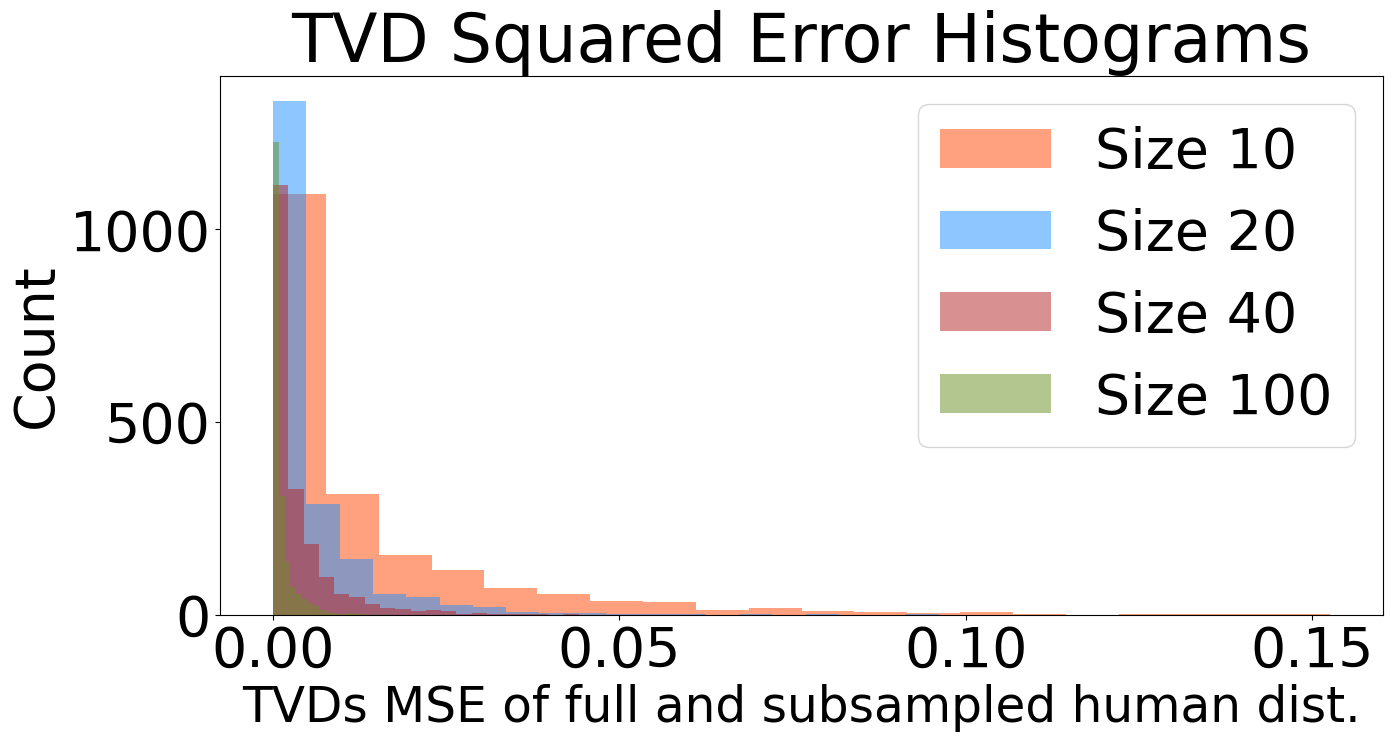

In [20]:
plt.rc('font', size=40)# controls default text sizes
plt.subplots(figsize=(15, 7))

plt.hist(mse_size_10, bins=20, alpha=0.5, label='Size 10', color = 'orangered')
plt.hist(mse_size_20, bins=20, alpha=0.5, label='Size 20', color = 'dodgerblue')
plt.hist(mse_size_40, bins=20, alpha=0.5, label='Size 40', color = 'firebrick')
plt.hist(mse_size_100, bins=20, alpha=0.5, label='Size 100', color = 'olivedrab')

plt.ylabel('Count', fontsize=40)
plt.xlabel('TVDs MSE of full and subsampled human dist.', fontsize=35)

plt.title("TVD Squared Error Histograms")
plt.legend(loc='upper right')
plt.savefig('ablation_size.pdf', format="pdf",bbox_inches='tight')
plt.show()